In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer()
Input = tf.keras.layers.Input
Embedding = tf.keras.layers.Embedding
Dense = tf.keras.layers.Dense
Concatenate = tf.keras.layers.Concatenate
Model = tf.keras.Model
simpleRNN = tf.keras.layers.SimpleRNN
LSTM = tf.keras.layers.LSTM
GRU = tf.keras.layers.GRU
dropout = tf.keras.layers.Dropout

import nltk
from nltk.corpus import stopwords

# nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
wnl = WordNetLemmatizer()

import re
import numpy as np

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve

2024-08-11 04:23:59.178595: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-11 04:23:59.195234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 04:23:59.213947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 04:23:59.219634: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-11 04:23:59.233268: I tensorflow/core/platform/cpu_feature_guar

In [2]:
df = pd.read_parquet("0000.parquet", engine="fastparquet")

In [3]:
df_hatespeech = df[["text", "hatespeech"]]

In [4]:
def keep_english_characters(text):
    return re.sub(r'[^A-Za-z0-9\s.,!?;\'\"#@-]', '', text)

In [5]:
df_hatespeech['cleaned_text'] = df_hatespeech['text'].apply(keep_english_characters)
df_hatespeech['text'] = df_hatespeech['cleaned_text']

0: Neutral or ambiguous <br>
1: Profanity            <br>
2: Hatespeech           <br>

In [6]:
#dropping rows with empty text
df_hatespeech = df_hatespeech[df_hatespeech['text'] != '']

In [7]:
df_hatespeech.shape

(135556, 3)

In [8]:
#drop rows with less than 3 words in text
df_hatespeech = df_hatespeech[df_hatespeech['text'].apply(lambda x: len(x.split()) > 5)]
df_hatespeech.shape

(126005, 3)

In [9]:
stopwords = stopwords.words('english')
stopwords.append('&amp;') # &amp; means and
def clean(df):
    df['text'] = df['text'].apply(lambda x: x.lower()) #lowercase
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])) #stopwords removal
    df['text'] = df['text'].apply(lambda x: re.sub(r'@[A-Za-z0-9]*', 'MENTION', x)) #replace all @mentions to 'MENTION'
    df['text'] = df['text'].apply(lambda x: re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'URL', x)) #replace all urls to 'URL'
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x)) #remove punctuation
    punct = '!"$%&\'()*+,-./:;<=>?[\\]^_{|}~'
    df['text'] = df['text'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punct)))
    df['text'] = df['text'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='a') for word in x.split()])) #lemmatize on the basis of adjectives
    df['text'] = df['text'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='v') for word in x.split()])) #lemmatize on the basis of verbs
    df['text'] = df['text'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='n') for word in x.split()])) #lemmatize on the basis of noun
    df['text'] = df['text'].apply(lambda x: re.sub(r'\bRT\b', '', x)) #remove RT
    return df

In [10]:
MAX_SEQ_LEN = 30
def tokenize(df):
    df['text'] = tokenizer.texts_to_sequences(df['text'])
    vocab_size = len(tokenizer.word_index) + 1
    print('Vocabulary size: {}'.format(vocab_size))
    padded_text = pad_sequences(df['text'].tolist(), padding='post', maxlen=MAX_SEQ_LEN)
    return padded_text, vocab_size

def preprocess(df):
    df = clean(df)
    df, vocab_size = tokenize(df)
    return df, vocab_size

In [11]:
X = df_hatespeech.drop(columns=['hatespeech'])
Y = df_hatespeech['hatespeech']
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=54)
print("Training Shape:", X_train.shape)
print("Validation Shape:", X_val.shape) 

Training Shape: (100804, 2)
Validation Shape: (25201, 2)


In [12]:
tokenizer.fit_on_texts(X_train['text'])
X_train, vocab_size = preprocess(X_train)
X_val, _ = preprocess(X_val)

Vocabulary size: 45171
Vocabulary size: 45171


In [13]:
word_index = tokenizer.word_index
embedding_index = {}
with open('glove_embeddings/glove.twitter.27B.200d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
# Create embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [14]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train.astype(int))
class_weights = dict(enumerate(class_weights))
# #If class weight is used, y needs to be one-hot encoded
Y_train_encoded = tf.keras.utils.to_categorical(Y_train, num_classes=3)
Y_val_encoded = tf.keras.utils.to_categorical(Y_val, num_classes=3)

## Baseline Models: Simple_RNN, LSTM and GRU

### Models

In [15]:
learning_rate = 0.00005

In [16]:
def model_LSTM(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(input_length,), name='text_input')
    x = Embedding(input_dim=vocab_size+1, output_dim=128, input_length=input_length)(text_input)
    x = LSTM(500, return_sequences=True)(x)
    x = dropout(0.8)(x)
    x = LSTM(300)(x)
    x = dropout(0.5)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [17]:
def model_RNN(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(input_length,), name='text_input')
    x = Embedding(input_dim=vocab_size+1, output_dim=128, input_length=MAX_SEQ_LEN)(text_input)
    x = simpleRNN(500)(x)
    x = dropout(0.8)(x)
    #add_input = Input(shape=(4,), name='additional_input')
    #x = Concatenate()([x, add_input])
    #x = Dense(64, activation='relu')(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
def model_GRU(vocab_size, input_length=MAX_SEQ_LEN):
    learning_rate = 0.00001
    text_input = Input(shape=(input_length,), name='text_input')
    x = Embedding(input_dim=vocab_size+1, output_dim=128, input_length=MAX_SEQ_LEN)(text_input)
    x = GRU(500)(x)
    x = dropout(0.8)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
def novel_model(vocab_size, input_length=MAX_SEQ_LEN, learning_rate=0.00003):
    Bidirectional = tf.keras.layers.Bidirectional
    model = tf.keras.Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=200, 
                        weights=[embedding_matrix], 
                        input_length=input_length, 
                        trainable=False))
    model.add(Bidirectional(GRU(40, activation='relu', return_sequences=True, name='BiDirectionalGRUlayer'))) #GRU layer with 40 units
    model.add(dropout(0.4)) #Dropout layer to prevent overfitting
    model.add(Bidirectional(LSTM(20, recurrent_activation='relu', return_sequences=True))) #LSTM layer with 20 units
    model.add(dropout(0.4)) #Dropout layer to prevent overfitting
    model.add(Dense(15)) #Dense layer with 16 units and relu activation function
    model.add(dropout(0.4)) #Dropout layer to prevent overfitting
    model.add(simpleRNN(10)) #SimpleRNN layer with 10 units
    model.add(dropout(0.4)) #Dropout layer to prevent overfitting
    model.add(Dense(10)) #Dense layer with 16 units and relu activation function
    model.add(Dense(3, activation='softmax')) #Output layer with 3 units and softmax activation function
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, use_ema=True, ema_momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Train and Test definitions

In [20]:
def train(model, X_train, Y_train, X_val, Y_val, epochs=100, batch_size=64):
      callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=6,
                                                      restore_best_weights=True)
      history = model.fit(X_train, Y_train, 
            validation_data=(X_val, Y_val), 
            epochs=epochs, batch_size=batch_size, 
            class_weight=class_weights,
            callbacks=callback,
            verbose=2)
      print("\n\n****************************\n\n")
      print("Model trained successfully")
      pred = model.predict(X_val, batch_size=batch_size, verbose=1, steps=None)
      y_true = np.argmax(Y_val, axis=1)
      y_pred = np.argmax(pred, axis=1)
      precision = precision_score(y_true, y_pred, average='weighted')
      recall = recall_score(y_true, y_pred, average='weighted')
      f1 = f1_score(y_true, y_pred, average='weighted')
      # Calculate AUC and plot ROC curve
      if Y_val.shape[1] == 2:  # Binary classification case
        auc = roc_auc_score(Y_val[:, 1], pred[:, 1])
        fpr, tpr, _ = roc_curve(Y_val[:, 1], pred[:, 1])
      else:  # Multi-class case (one-vs-rest approach)
        auc = roc_auc_score(Y_val, pred, multi_class='ovr', average='weighted')
        fpr, tpr, _ = roc_curve(Y_val.ravel(), pred.ravel())
    
      print("AUC: ", auc)
      print("Precision: ", precision, "Recall: ", recall, "F1 Score: ", f1)
      print("Validation Accuracy: ", model.evaluate(X_val, Y_val, batch_size=batch_size, verbose=1))
      
      # Plot ROC curve
      plt.figure(figsize=(8, 6))
      plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
      plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic (ROC) Curve')
      plt.legend(loc='lower right')
      plt.show()
      
      return history

In [21]:
def evaluate_model(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, len(train_accuracy)), train_accuracy, 'b-', linewidth=2, label='Training Accuracy')
    plt.plot(range(0, len(val_accuracy)), val_accuracy, 'r-', linewidth=2, label='Validation Accuracy')
    plt.title('Training & validation accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(train_loss)), train_loss, 'b-', linewidth=2, label='Training Loss')
    plt.plot(range(0, len(val_loss)), val_loss, 'r-', linewidth=2, label='Validation Loss')
    plt.title('Training & validation loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

### Training of BaseLine Models

I0000 00:00:1723350328.284731    4123 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723350328.334067    4123 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723350328.335780    4123 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723350328.339443    4123 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/100


2024-08-11 04:25:31.660493: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


197/197 - 18s - 90ms/step - accuracy: 0.5880 - loss: 0.9312 - val_accuracy: 0.6695 - val_loss: 0.7886
Epoch 2/100
197/197 - 14s - 73ms/step - accuracy: 0.6347 - loss: 0.8439 - val_accuracy: 0.6611 - val_loss: 0.7917
Epoch 3/100
197/197 - 14s - 73ms/step - accuracy: 0.6415 - loss: 0.8105 - val_accuracy: 0.6717 - val_loss: 0.7810
Epoch 4/100
197/197 - 14s - 73ms/step - accuracy: 0.6598 - loss: 0.7779 - val_accuracy: 0.6258 - val_loss: 0.7989
Epoch 5/100
197/197 - 14s - 73ms/step - accuracy: 0.6785 - loss: 0.7436 - val_accuracy: 0.6510 - val_loss: 0.7895
Epoch 6/100
197/197 - 14s - 73ms/step - accuracy: 0.7002 - loss: 0.7036 - val_accuracy: 0.6688 - val_loss: 0.8058
Epoch 7/100
197/197 - 14s - 73ms/step - accuracy: 0.7220 - loss: 0.6673 - val_accuracy: 0.6428 - val_loss: 0.8241
Epoch 8/100
197/197 - 14s - 73ms/step - accuracy: 0.7307 - loss: 0.6385 - val_accuracy: 0.6354 - val_loss: 0.8512
Epoch 9/100
197/197 - 14s - 74ms/step - accuracy: 0.7440 - loss: 0.6113 - val_accuracy: 0.6743 - val

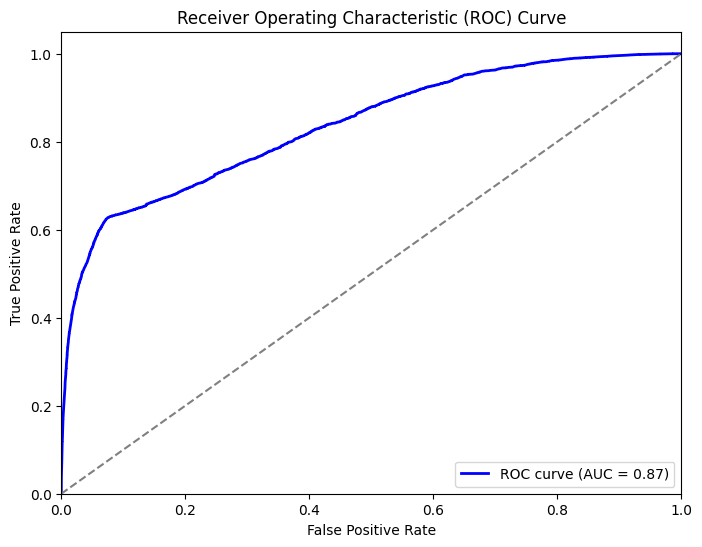

In [22]:
m = model_LSTM(vocab_size)
history_LSTM = train(m, X_train, Y_train_encoded, X_val, Y_val_encoded, epochs=100, batch_size=512) 

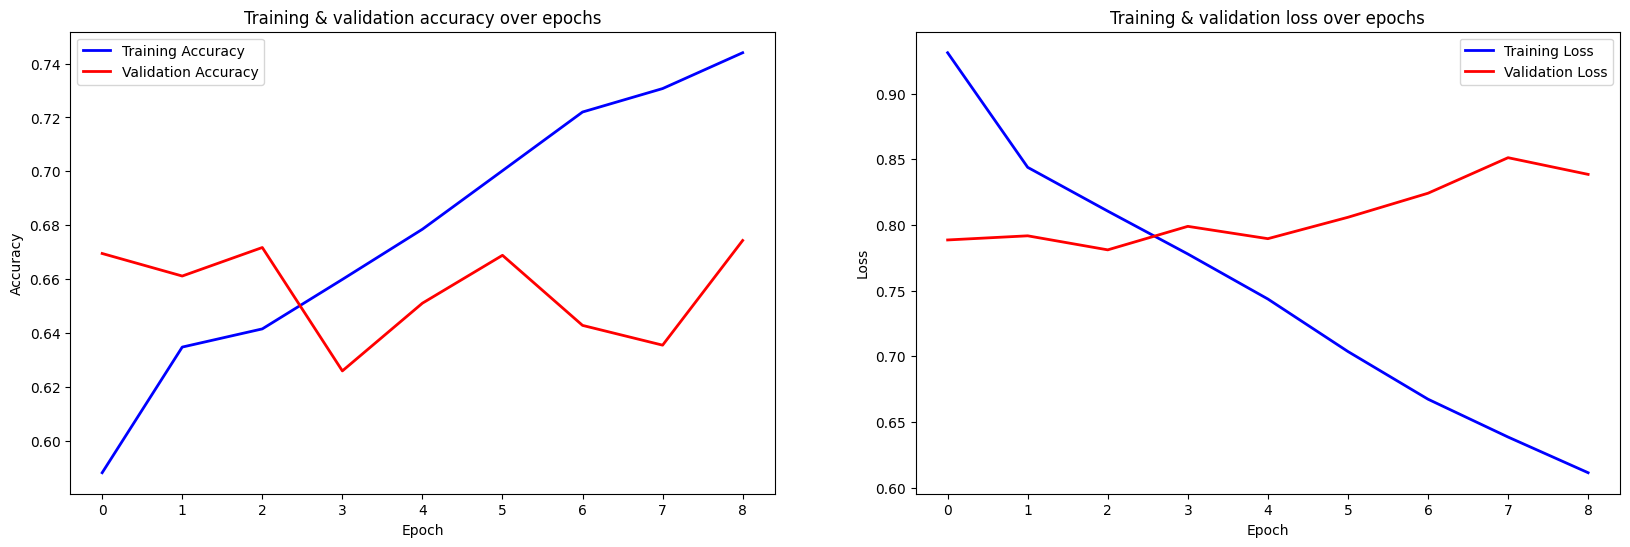

In [23]:
evaluate_model(history_LSTM)

Epoch 1/100


I0000 00:00:1723350466.717231    4401 service.cc:146] XLA service 0x4895e090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723350466.717255    4401 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-11 04:27:46.770557: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-11 04:27:47.674236: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:1723350468.207921    4401 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once fo

197/197 - 8s - 39ms/step - accuracy: 0.5373 - loss: 0.9938 - val_accuracy: 0.6210 - val_loss: 0.8633
Epoch 2/100
197/197 - 3s - 16ms/step - accuracy: 0.6345 - loss: 0.8975 - val_accuracy: 0.6721 - val_loss: 0.8046
Epoch 3/100
197/197 - 3s - 16ms/step - accuracy: 0.6535 - loss: 0.8624 - val_accuracy: 0.6574 - val_loss: 0.8136
Epoch 4/100
197/197 - 3s - 16ms/step - accuracy: 0.6662 - loss: 0.8328 - val_accuracy: 0.6488 - val_loss: 0.8034
Epoch 5/100
197/197 - 3s - 16ms/step - accuracy: 0.6791 - loss: 0.8078 - val_accuracy: 0.6364 - val_loss: 0.8321
Epoch 6/100
197/197 - 3s - 16ms/step - accuracy: 0.6916 - loss: 0.7810 - val_accuracy: 0.6741 - val_loss: 0.7893
Epoch 7/100
197/197 - 3s - 16ms/step - accuracy: 0.7058 - loss: 0.7528 - val_accuracy: 0.6847 - val_loss: 0.7685
Epoch 8/100
197/197 - 3s - 16ms/step - accuracy: 0.7146 - loss: 0.7263 - val_accuracy: 0.6847 - val_loss: 0.7714
Epoch 9/100
197/197 - 3s - 16ms/step - accuracy: 0.7278 - loss: 0.6972 - val_accuracy: 0.6770 - val_loss: 0.

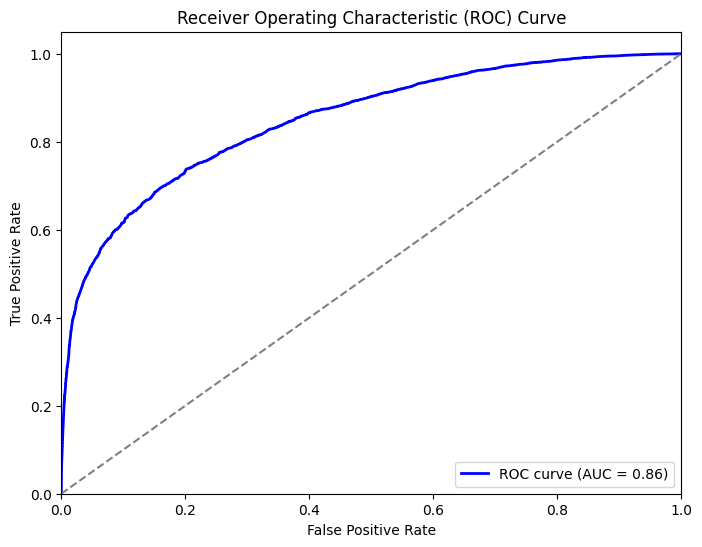

In [24]:
m = model_RNN(vocab_size, input_length=MAX_SEQ_LEN)
history_RNN = train(m, X_train, Y_train_encoded, X_val, Y_val_encoded, epochs=100, batch_size=512) 

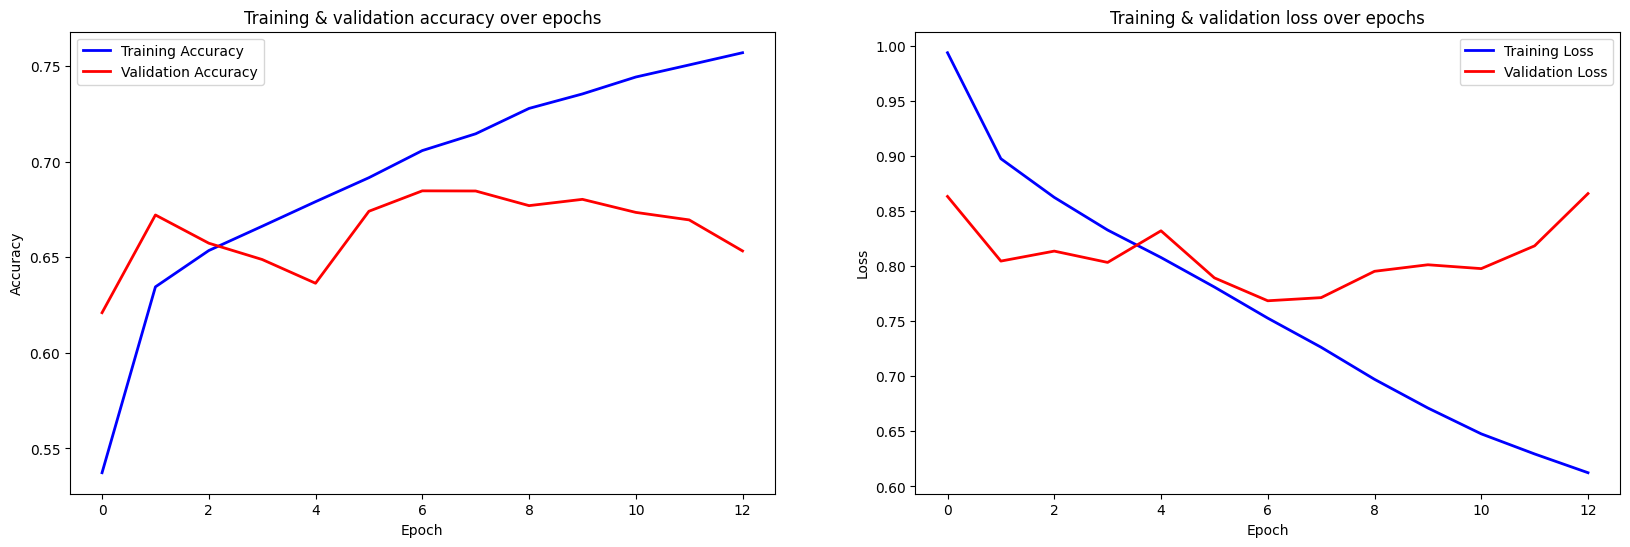

In [25]:
evaluate_model(history_RNN)

Epoch 1/100
394/394 - 10s - 25ms/step - accuracy: 0.3338 - loss: 1.0987 - val_accuracy: 0.1236 - val_loss: 1.0986
Epoch 2/100
394/394 - 9s - 22ms/step - accuracy: 0.3416 - loss: 1.0977 - val_accuracy: 0.1273 - val_loss: 1.0998
Epoch 3/100
394/394 - 9s - 22ms/step - accuracy: 0.3365 - loss: 1.0962 - val_accuracy: 0.1270 - val_loss: 1.0988
Epoch 4/100
394/394 - 9s - 22ms/step - accuracy: 0.3097 - loss: 1.0926 - val_accuracy: 0.1564 - val_loss: 1.0889
Epoch 5/100
394/394 - 9s - 22ms/step - accuracy: 0.6471 - loss: 0.9611 - val_accuracy: 0.7149 - val_loss: 0.7995
Epoch 6/100
394/394 - 9s - 22ms/step - accuracy: 0.6982 - loss: 0.8882 - val_accuracy: 0.6971 - val_loss: 0.7862
Epoch 7/100
394/394 - 9s - 22ms/step - accuracy: 0.6818 - loss: 0.8703 - val_accuracy: 0.6858 - val_loss: 0.7816
Epoch 8/100
394/394 - 9s - 22ms/step - accuracy: 0.6742 - loss: 0.8567 - val_accuracy: 0.6614 - val_loss: 0.7930
Epoch 9/100
394/394 - 9s - 22ms/step - accuracy: 0.6690 - loss: 0.8478 - val_accuracy: 0.6697 -

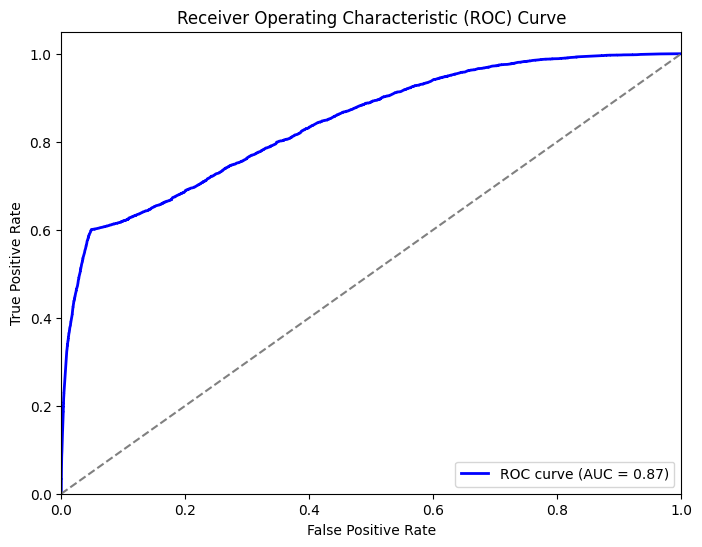

In [26]:
m = model_GRU(vocab_size, input_length=MAX_SEQ_LEN)
history_GRU = train(m, X_train, Y_train_encoded, X_val, Y_val_encoded, epochs=100, batch_size=256) 

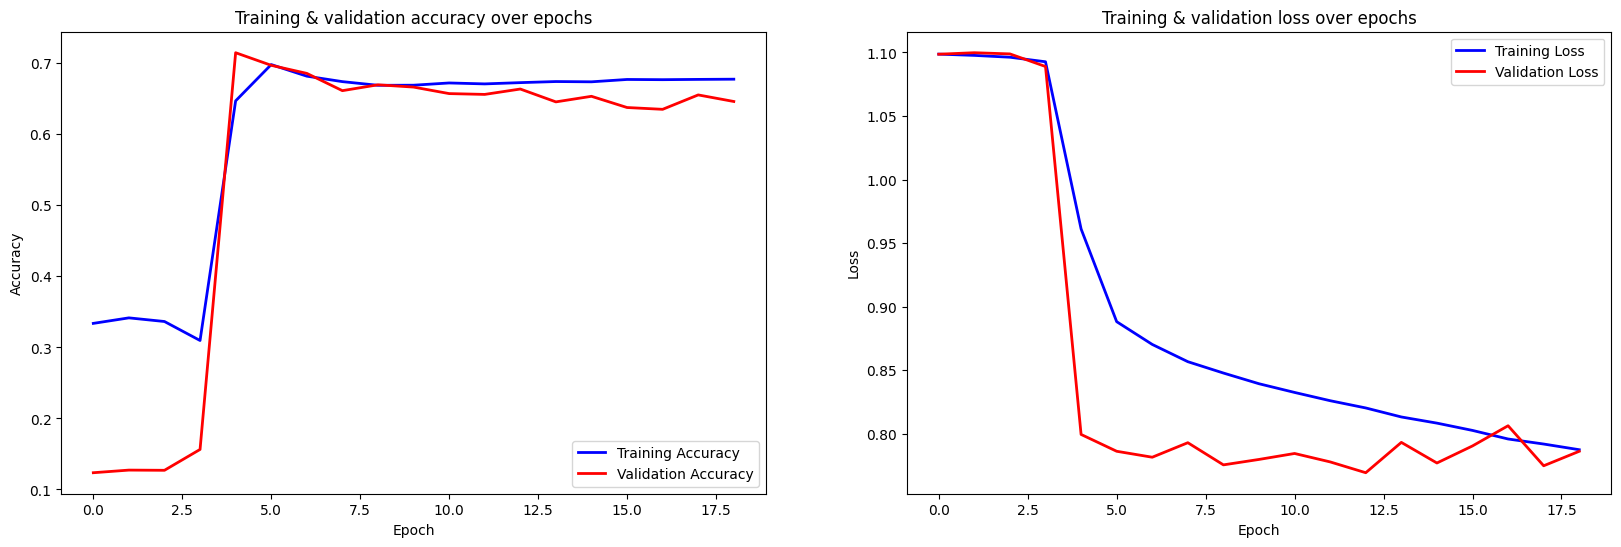

In [27]:
evaluate_model(history_GRU)

### Training of Novel Model

Epoch 1/100


394/394 - 23s - 58ms/step - accuracy: 0.3309 - loss: 1.1335 - val_accuracy: 0.2723 - val_loss: 1.1235
Epoch 2/100
394/394 - 8s - 21ms/step - accuracy: 0.3293 - loss: 1.1283 - val_accuracy: 0.2838 - val_loss: 1.1173
Epoch 3/100
394/394 - 8s - 21ms/step - accuracy: 0.3298 - loss: 1.1250 - val_accuracy: 0.2545 - val_loss: 1.1185
Epoch 4/100
394/394 - 8s - 21ms/step - accuracy: 0.3333 - loss: 1.1184 - val_accuracy: 0.2363 - val_loss: 1.1165
Epoch 5/100
394/394 - 8s - 21ms/step - accuracy: 0.3284 - loss: 1.1163 - val_accuracy: 0.2321 - val_loss: 1.1135
Epoch 6/100
394/394 - 8s - 21ms/step - accuracy: 0.3286 - loss: 1.1143 - val_accuracy: 0.2292 - val_loss: 1.1127
Epoch 7/100
394/394 - 8s - 21ms/step - accuracy: 0.3280 - loss: 1.1132 - val_accuracy: 0.2120 - val_loss: 1.1136
Epoch 8/100
394/394 - 8s - 21ms/step - accuracy: 0.3220 - loss: 1.1120 - val_accuracy: 0.2105 - val_loss: 1.1119
Epoch 9/100
394/394 - 8s - 21ms/step - accuracy: 0.3211 - loss: 1.1092 - val_accuracy: 0.2141 - val_loss: 1

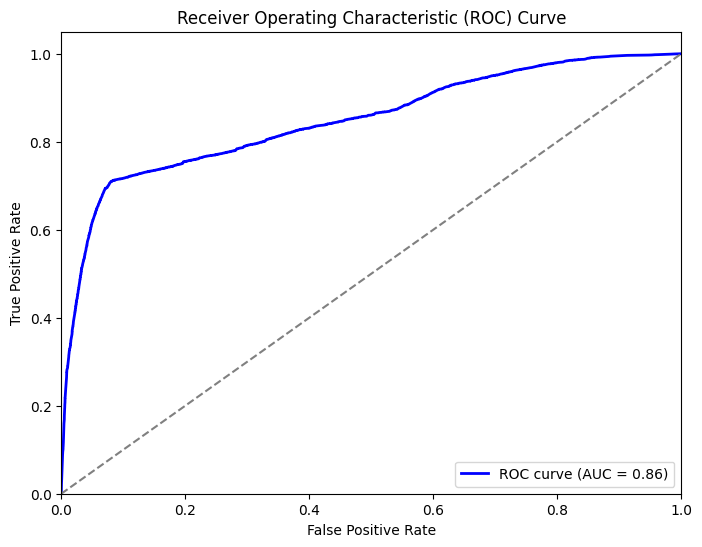

In [32]:
m = novel_model(vocab_size, input_length=MAX_SEQ_LEN, learning_rate=0.00001)
history = train(m, X_train, Y_train_encoded, X_val, Y_val_encoded, epochs=100, batch_size=256)  

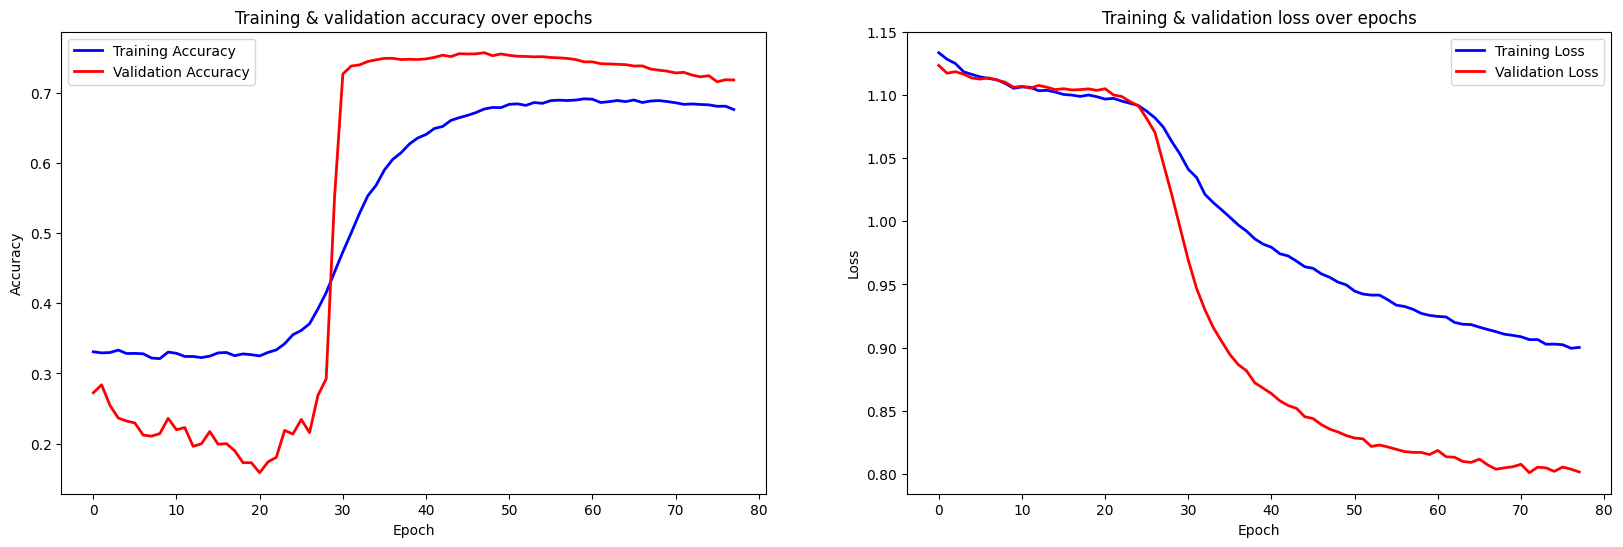

In [33]:
evaluate_model(history)